In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv
import os
import sys
sys.path.append("..")
import minimise
import pandas as pd
import scipy.constants as const


# Enable or disable Tensor Float 32 Execution
tf.config.experimental.enable_tensor_float_32_execution(False)
import matplotlib.pyplot as plt
from scipy.integrate import simpson

params = {"axes.labelsize": 14,
          "axes.titlesize": 16,}
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update(params)

def place(ax):
  ax.tick_params(direction="in", which="minor", length=3)
  ax.tick_params(direction="in", which="major", length=5, labelsize=13)
  ax.grid(which="major", ls="dashed", dashes=(1, 3), lw=0.8, zorder=0)
  #ax.legend(frameon=True, loc="best", fontsize=12,edgecolor="black")
  fig.tight_layout()

In [11]:

def generate_windows(array, bins):
    """
    Generate sliding windows for the input array with a given bin size.

    Parameters:
    - array (np.ndarray): Input array.
    - bins (int): Number of bins on each side of the central bin.
    - mode (str): Padding mode for np.pad (default is "wrap").

    Returns:
    - np.ndarray: Array of sliding windows.
    """
    padded_array = np.pad(array, bins, mode="wrap")
    windows = np.empty((len(array), 2 * bins + 1))
    for i in range(len(array)):
        windows[i] = padded_array[i:i + 2 * bins + 1]
    return windows


def c1_twotype(model_H, model_O, rho_H, rho_O, input_bins=667, dx=0.03, return_c2=False):
    """
    Infer the one-body direct correlation profile from a given density profile 
    using a neural correlation functional.

    Parameters:
    - model (tf.keras.Model): The neural correlation functional.
    - density_profile (np.ndarray): The density profile.
    - dx (float): The discretization of the input layer of the model.
    - input_bins (int): Number of input bins for the model.
    - return_c2 (bool or str): If False, only return c1(x). If True, return both 
                               c1 as well as the corresponding two-body direct 
                               correlation function c2(x, x') which is obtained 
                               via autodifferentiation. If 'unstacked', give c2 
                               as a function of x and x-x', i.e., as obtained 
                               naturally from the model.

    Returns:
    - np.ndarray: c1(x) or (c1(x), c2(x, x')) depending on the value of return_c2.
    """
    window_bins = (input_bins - 1) // 2
    rhoH_windows = generate_windows(rho_H, window_bins).reshape(rho_H.shape[0], input_bins, 1)
    rhoO_windows = generate_windows(rho_O, window_bins).reshape(rho_O.shape[0], input_bins, 1)
    
    if return_c2:
        rhoH_windows = tf.Variable(rhoH_windows)
        rhoO_windows = tf.Variable(rhoO_windows)
        with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
            tape.watch(rhoO_windows)
            tape.watch(rhoH_windows)
            H_result = model_H(rhoH_windows, rhoO_windows)
            O_result = model_O(rhoH_windows, rhoO_windows)
        jacobi_windows_HH = tape.batch_jacobian(H_result, rhoH_windows).numpy().squeeze() / dx
        jacobi_windows_HO = tape.batch_jacobian(H_result, rhoO_windows).numpy().squeeze() / dx
        jacobi_windows_OO = tape.batch_jacobian(O_result, rhoO_windows).numpy().squeeze() / dx
        jacobi_windows_OH = tape.batch_jacobian(O_result, rhoH_windows).numpy().squeeze() / dx
       
        c1H_result = H_result.numpy().flatten()
        c1O_result = O_result.numpy().flatten()
        
        if return_c2 == "unstacked":
            return c1H_result, c1O_result, jacobi_windows_HH, jacobi_windows_HO, jacobi_windows_OO, jacobi_windows_OH
        
        c2_result_HH = np.row_stack([
            np.roll(np.pad(jacobi_windows_HH[i], (0, rho_H.shape[0] - input_bins)), i - window_bins) 
            for i in range(rho_H.shape[0])
        ])
        c2_result_HO = np.row_stack([
            np.roll(np.pad(jacobi_windows_HO[i], (0, rho_H.shape[0] - input_bins)), i - window_bins) 
            for i in range(rho_H.shape[0])
        ])
        c2_result_OO = np.row_stack([
            np.roll(np.pad(jacobi_windows_OO[i], (0, rho_H.shape[0] - input_bins)), i - window_bins) 
            for i in range(rho_H.shape[0])
        ])
        c2_result_OH = np.row_stack([
            np.roll(np.pad(jacobi_windows_OH[i], (0, rho_H.shape[0] - input_bins)), i - window_bins) 
            for i in range(rho_H.shape[0])
        ])
        
        return (c1H_result, c2_result_HH, c2_result_HO), (c1O_result, c2_result_OO, c2_result_OH)



    c1H_result = model_H.predict_on_batch([rhoH_windows, rhoO_windows]).flatten()
    c1O_result = model_O.predict_on_batch([rhoO_windows, rhoH_windows]).flatten()
    return c1H_result, c1O_result


def betaFexc_twotype(model_H, model_O, rho_H, rho_O, dx=0.03):
    """
    Calculate the excess free energy Fexc for a given density profile with functional line integration.

    model: The neural correlation functional
    rho: The density profile
    dx: The discretization of the input layer of the model
    """
    alphas = np.linspace(0, 1, 50)
    integrands = np.empty_like(alphas)
    for i, alpha in enumerate(alphas):
        
        c1H, c1O = c1_twotype(model_H, model_O, alpha * rho_H, alpha * rho_O)
        
        integrands[i] = np.sum(rho_H * c1H + rho_O * c1O) * dx
    Fexc = -simpson(integrands, x=alphas)
    return Fexc



In [12]:
kB  = 1.38064852e-23
T = 8000

model_H_path = "../../models/21PM_H_Dec23.keras"
model_O_path = "../../models/21PM_O_Dec23.keras"

model_H = keras.models.load_model(model_H_path)
model_O = keras.models.load_model(model_O_path)


rho_range = np.linspace(0.0, 0.04, 50)
Fexc_range = np.empty_like(rho_range)
derivPhiH = np.empty_like(rho_range)
derivPhiO = np.empty_like(rho_range)
betamuH = np.empty_like(rho_range)
betamuO = np.empty_like(rho_range)
z_range = np.ones(1)


for i in range(len(rho_range)):
    
    rhoH_array = z_range * rho_range[i]*2/3
    rhoO_array = z_range * rho_range[i]*1/3
    
    Fexc_range[i] = kB * T * betaFexc_twotype(model_H, model_O, rhoH_array, rhoO_array, dx=0.03)
    c1H, c1O, = c1_twotype(model_H, model_O, rhoH_array, rhoO_array)
    derivPhiH[i] = -np.mean(c1H) * kB * T
    derivPhiO[i] = -np.mean(c1O) * kB * T
    
    betamuH[i] = np.log(np.mean(rhoH_array)) - np.mean(c1H)
    betamuO[i] = np.log(np.mean(rhoO_array)) - np.mean(c1O)
    
    


I0000 00:00:1739359020.377147 2140056 service.cc:145] XLA service 0x7f03b8002200 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739359020.377186 2140056 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1739359020.548592 2140056 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/tmp/ipykernel_2139925/180369692.py:30: RuntimeWarning: divide by zero encountered in log
  betamuH[i] = np.log(np.mean(rhoH_array)) - np.mean(c1H)
/tmp/ipykernel_2139925/180369692.py:31: RuntimeWarning: divide by zero encountered in log
  betamuO[i] = np.log(np.mean(rhoO_array)) - np.mean(c1O)


In [13]:
P_range = (derivPhiH + kB*T) * rho_range *2/3 + (derivPhiO + kB*T) * rho_range * 1/3  - Fexc_range/0.03

In [14]:

path = "/scratch/btb32/gcmc-training/21pm-bulk/sr/pressure_sr.txt"
data = pd.read_csv(path, skiprows=1, header=None, sep=r'\s+').to_numpy()

rho_sim = data[:,0]
P_sim = data[:,1]
P_err_sim = data[:,2]



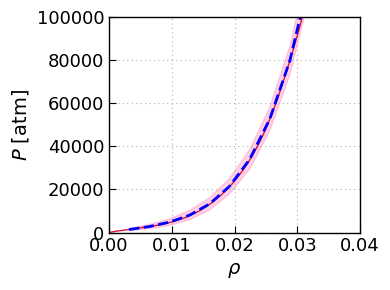

In [15]:
angtrom3_to_m3 = 1e30
pa_to_atm = 101325

P_range_atm = P_range * angtrom3_to_m3/pa_to_atm

fig, ax = plt.subplots(1, 1, figsize=(4,3))

ax.plot(rho_range, P_range_atm, lw=1, color="crimson")
ax.plot(rho_sim, P_sim, lw=2, color="blue", ls="--")
ax.fill_between(rho_sim, P_sim-P_err_sim, P_sim+P_err_sim, color="hotpink", alpha=0.3)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$P$ [atm]")
ax.set_ylim(0, 100000)
ax.set_xlim(0, 0.04)
place(ax)

#with open('/scratch/btb32/cdft-ions-paper/data/pressure_sr_21pm.dat', 'w', newline='') as csvfile:
#        writer = csv.writer(csvfile, delimiter=' ')
#        writer.writerow(["tot_rho [per AA cubed]", "pressure [atm]"])
#        for x, y in zip(rho_range, P_range_atm):
#            writer.writerow([f"{x:.10f}", f"{y:.10f}"])

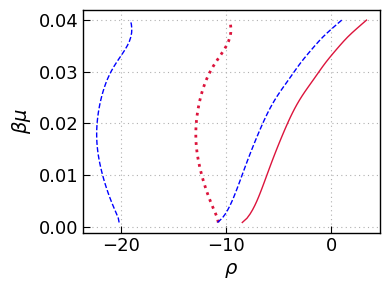

In [16]:
def mu_correction(q, sigma, temp):
    prefactor = const.elementary_charge**2 /(4 * const.pi * const.epsilon_0 * 1e-10 )
    beta = 1/ (const.Boltzmann * temp) 

    first = - q**2 / (sigma * np.pi**0.5  )
    return prefactor*first*beta



fig, ax = plt.subplots(1, 1, figsize=(4,3))

ax.plot(betamuH, rho_range, lw=1, color="crimson", label=r"8000")
ax.plot(betamuO, rho_range, lw=2, color="crimson", ls=':')
ax.plot(betamuH+mu_correction(1, 5, 8000), rho_range, lw=1, color="blue", ls='--')
ax.plot(betamuO+mu_correction(2, 5, 8000), rho_range, lw=1, color="blue", ls='--')

ax.set_ylabel(r"$\beta\mu$")
ax.set_xlabel(r"$\rho$")

place(ax)



In [17]:


def get_mu_LR(density):
    
    rhoH_array = np.array([1]) * density*2/3
    rhoO_array = np.array([1])  * density*1/3
    c1H, c1O, = c1_twotype(model_H, model_O, rhoH_array, rhoO_array)
    mu_H = np.log(np.mean(rhoH_array)) - np.mean(c1H)
    mu_O = np.log(np.mean(rhoO_array)) - np.mean(c1O)
    return mu_H + mu_correction(1, 5, 8000), mu_O + mu_correction(2, 5, 8000)


In [18]:
print(0.005, get_mu_LR(0.005))
print(0.010, get_mu_LR(0.010))
print(0.015, get_mu_LR(0.015))
print(0.020, get_mu_LR(0.020))
print(0.025, get_mu_LR(0.025))
print(0.030, get_mu_LR(0.030))

0.005 (-9.422832987570972, -20.93413529650536)
0.01 (-8.474506401798624, -21.743357519784524)
0.015 (-7.543501418659942, -22.225497125116302)
0.02 (-6.5138659136481945, -22.264863831198454)
0.025 (-5.229272655779572, -21.858344444465544)
0.03 (-3.52265576893801, -20.94709003015816)
